In [1]:
%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt
from cmocean import cm as cmo
plt.style.use('seaborn-poster')
plt.style.use('ggplot')

import numpy as np
import pandas as pd
import xarray as xr
import scipy
import glob
import matplotlib.dates as mdates
import datetime
import dask.array as da

In [2]:
import cartopy.crs as ccrs
import cartopy
import matplotlib.gridspec as gridspec # GRIDSPEC !
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

In [3]:
hurrloc = "../data/track_data/IRENE_2011"

df = pd.read_csv(hurrloc, skiprows=1)
hermlen = len(df[df.columns[0]])

hurrnum = np.ones(hermlen)
for i in range(hermlen):
    yearmoda = str(df[df.columns[0]][i])
    hours    = int(df[df.columns[1]][i]/100)
    dateform = datetime.datetime(int(yearmoda[:4]), int(yearmoda[4:6]), int(yearmoda[6:]), hours)
    hurrnum[i] = mdates.date2num(dateform)

latsN, lonsN = df.columns[4], df.columns[5]

hurrlats = [float(df[latsN][i][:-1]) for i in range(len(df[df.columns[0]]))]
hurrlons = [-float(df[lonsN][i][:-1]) for i in range(len(df[df.columns[0]]))]

In [4]:
ru16_url = 'http://tds.marine.rutgers.edu/thredds/dodsC/cool/glider/mab/Gridded/20110810T1330_epa_ru16_active.nc'
ru16     = xr.open_dataset(ru16_url)

In [5]:
list(ru16)

['latitude', 'longitude', 'temperature', 'salinity']

In [6]:
ru16

<xarray.Dataset>
Dimensions:      (depth: 60, profile: 5794)
Coordinates:
    time         (profile) datetime64[ns] ...
  * depth        (depth) float64 -1.0 -3.0 -5.0 -7.0 ... -115.0 -117.0 -119.0
Dimensions without coordinates: profile
Data variables:
    latitude     (profile) float64 ...
    longitude    (profile) float64 ...
    temperature  (profile, depth) float64 ...
    salinity     (profile, depth) float64 ...
Attributes:
    Conventions:                     CF-1.0
    Title:                           Rutgers University COOL glider data on s...
    source:                          
    Institution:                     Institute for Marine and Coastal Science...
    history:                         Created by /home/om/cron/glider/glider_h...
    DODS_EXTRA.Unlimited_Dimension:  profile

In [7]:
ru16['mdate'] = mdates.date2num(ru16.time)

In [8]:
from geopy.distance import geodesic

glats = np.squeeze(ru16.latitude.values)
glons = np.squeeze(ru16.longitude.values)

distance_metric = np.ones((np.size(glats),np.size(hurrlats)))
for i, glatitude in enumerate(glats):
    for j, hlatitude in enumerate(hurrlats):
        glider_LL = (glatitude, glons[i])
        hurr_ll   = (hlatitude, hurrlons[j])
        distance_metric[i,j] = geodesic(glider_LL, hurr_ll).miles

In [9]:
b = np.amin(distance_metric)
print(b)
ktime = np.where(distance_metric == b)[1][0]
eyepassage = hurrnum[ktime]
eyepassage

8.087266775303725


15214.375

In [10]:
print(ru16.mdate.shape, ru16.depth.shape)
D, MDATE = np.meshgrid(ru16.depth.values,ru16.mdate.values)
start    = mdates.date2num(datetime.datetime(2011,8,27))
plend    = mdates.date2num(datetime.datetime(2011,8,30))
myFmt = mdates.DateFormatter('%m/%d\n%H:%M')

(5794,) (60,)


/Users/cew145/miniconda3/envs/pangeo/lib/python3.6/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  


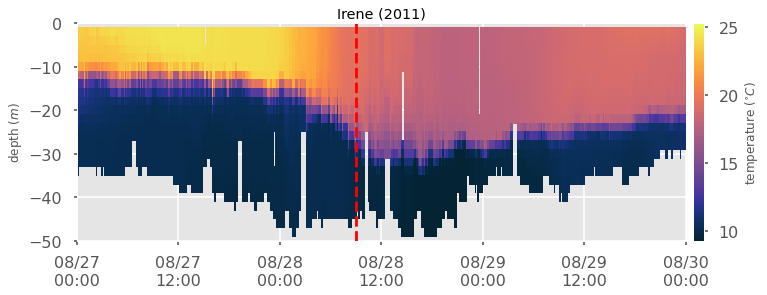

In [11]:
plt.figure(figsize=(13,4))
plt.pcolor(MDATE, D, ru16.temperature, cmap=cmo.thermal)
plt.colorbar(label='temperature ($^{\circ}C$)',pad=0.01)
plt.ylim([-50,0])
plt.xlim([start,plend])
plt.ylabel('depth ($m$)')
plt.axvline(x = eyepassage, c='r', linestyle="--")
plt.gca().xaxis.set_major_formatter(myFmt)
plt.grid()
plt.title('Irene (2011)')
plt.savefig("FIGS/temperature_Irene2011.pdf", bbox_inches='tight')
plt.show()

In [12]:
TEMPS = ru16.temperature.values
times = mdates.date2num(ru16.time.values)

In [13]:
st = mdates.date2num(datetime.datetime(2011,8,27,0))
en = mdates.date2num(datetime.datetime(2011,8,27,18))

a = times < en
b = times > st
q = np.logical_and(a,b)
temps_before = TEMPS[q,:]
temps_before = np.nanmean(temps_before, axis=(0))

/Users/cew145/miniconda3/envs/pangeo/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice
  


/Users/cew145/miniconda3/envs/pangeo/lib/python3.6/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  


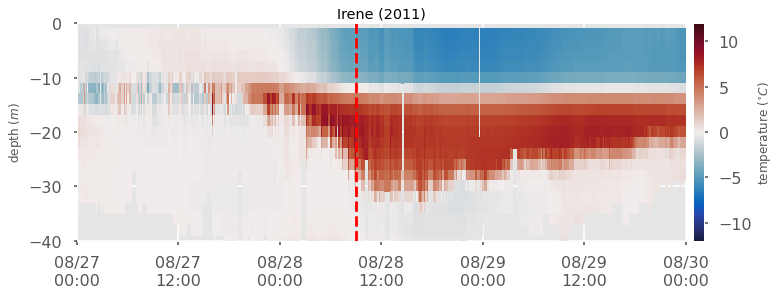

In [14]:
plt.figure(figsize=(13,4))
plt.pcolor(MDATE, D, ru16.temperature.values - temps_before[np.newaxis,:], cmap=cmo.balance, vmin=-12, vmax=12)
plt.colorbar(label='temperature ($^{\circ}C$)',pad=0.01)
plt.ylim([-40,0])
plt.ylabel('depth ($m$)')
myFmt = mdates.DateFormatter('%m/%d\n%H:%M')
plt.axvline(x = eyepassage, c='r', linestyle="--")
plt.xlim([start,plend])
plt.gca().xaxis.set_major_formatter(myFmt)
plt.grid()
plt.title('Irene (2011)')
plt.savefig("FIGS/dT_Irene2011.pdf", bbox_inches='tight')
plt.show()

In [15]:
bouy           = '/Users/cew145/Documents/codar_data/ndb_44009_2011_winds.txt'
b65            = '/Users/cew145/Documents/codar_data/ndb_44065_2011_winds.txt'
tuckerton_file = '/Users/cew145/Desktop/Irene_comps/Tuckerton_weatherflow.csv'

In [16]:
ndb = pd.read_csv(bouy, skiprows=[1], delim_whitespace=True)
d65 = pd.read_csv(b65, skiprows=[1], delim_whitespace=True)
tck = pd.read_csv(tuckerton_file, delimiter=",")

In [17]:
from dateutil.parser import parse

In [18]:
tck_datenum = np.ones(len(tck))
for i, datecode in enumerate(tck['time_stamp'][:]):
    tck_datenum[i] = mdates.date2num(parse(datecode))
    
tck['datenum'] = tck_datenum

In [19]:
tck

,station_id,time_stamp,average,lull,gust,direction,air_temp,pressure,water_temp,rh,datenum
0,37558,2011-08-20 04:00:00.0 UTC,1.832864,1.475232,2.190496,335.0,69.0,1011.9,NaN,NaN,15206.166667
1,37558,2011-08-20 04:05:00.0 UTC,1.877568,1.519936,2.235200,342.0,68.9,1011.9,NaN,NaN,15206.170139
2,37558,2011-08-20 04:10:00.0 UTC,1.743456,1.296416,2.190496,348.0,68.9,1011.8,NaN,NaN,15206.173611
3,37558,2011-08-20 04:15:00.0 UTC,1.788160,1.609344,1.966976,351.0,68.8,1011.7,NaN,NaN,15206.177083
4,37558,2011-08-20 04:20:00.0 UTC,2.011680,1.475232,2.548128,354.0,68.7,1011.7,NaN,NaN,15206.180556
...,...,...,...,...,...,...,...,...,...,...,...
4604,37558,2011-09-05 03:40:00.0 UTC,5.543296,3.755136,7.063232,201.0,71.3,1010.2,NaN,NaN,15222.152778
4605,37558,2011-09-05 03:45:00.0 UTC,5.185664,3.621024,7.018528,202.0,71.2,1010.2,NaN,NaN,15222.156250
4606,37558,2011-09-05 03:50:00.0 UTC,5.588000,4.023360,7.063232,201.0,71.3,1010.2,NaN,NaN,15222.159722
4607,37558,2011-09-05 03:55:00.0 UTC,5.185664,3.486912,6.884416,201.0,71.2,1010.3,NaN,NaN,15222.163194


In [20]:
ndb_datenum = [mdates.date2num(datetime.datetime(ndb['#YY'][i],ndb['MM'][i],ndb['DD'][i],ndb['hh'][i],ndb['mm'][i])) 
               for i in range(len(ndb))]
ndb['datenum'] = ndb_datenum

_datenum_65 = [mdates.date2num(datetime.datetime(d65['#YY'][i],d65['MM'][i],d65['DD'][i],d65['hh'][i],d65['mm'][i])) 
               for i in range(len(d65))]
d65['datenum'] = _datenum_65

In [25]:
rotation = 360
number_of_spins = 0

wind_dir_total = np.ones_like(ndb['WDIR'])
wind_dir_total[0] = ndb['WDIR'][0]
for i in range(len(ndb)-1):
    j = i+1
    if ndb['WDIR'][j-1] > 260 and ndb['WDIR'][j] < 100:
        number_of_spins += 1
    if ndb['WDIR'][j-1] < 100 and ndb['WDIR'][j] > 260:
        number_of_spins -= 1
    wind_dir_total[j] = ndb['WDIR'][j] + rotation*number_of_spins

dtheta = np.gradient(wind_dir_total)

In [26]:
number_of_spins = 0
wind_dir_total_65 = np.ones_like(d65['WDIR'])
wind_dir_total_65[0] = d65['WDIR'][0]
for i in range(len(d65)-1):
    j = i+1
    if d65['WDIR'][j-1] > 260 and d65['WDIR'][j] < 100:
        number_of_spins += 1
    if d65['WDIR'][j-1] < 100 and d65['WDIR'][j] > 260:
        number_of_spins -= 1
    wind_dir_total_65[j] = d65['WDIR'][j] + rotation*number_of_spins

dtheta_65 = np.gradient(wind_dir_total_65)

In [27]:
number_of_spins = 0
wind_dir_total_tck = np.ones_like(tck['direction'])
wind_dir_total_tck[0] = tck['direction'][0]
for i in range(len(tck)-1):
    j = i+1
    if tck['direction'][j-1] > 260 and tck['direction'][j] < 100:
        number_of_spins += 1
    if tck['direction'][j-1] < 100 and tck['direction'][j] > 260:
        number_of_spins -= 1
    wind_dir_total_tck[j] = tck['direction'][j] + rotation*number_of_spins

    
dtheta_tck = np.gradient(wind_dir_total_tck)

In [28]:
dTtck = np.gradient(tck['datenum']) * 86400
dT65  = np.gradient(d65['datenum']) * 86400
dT09  = np.gradient(ndb['datenum']) * 86400

In [35]:
import scipy.signal as sig

k = np.argmin(ndb['PRES'][start:finish])
ndb['datenum'][5690+k]

15214.284722222223

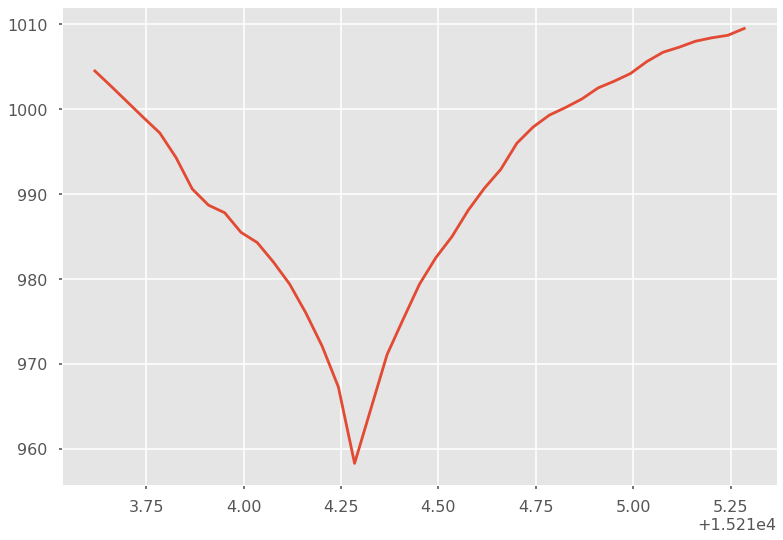

In [30]:
start = 5690
finish = 5730
plt.plot(ndb['datenum'][start:finish],ndb['PRES'][start:finish])

In [42]:
filtwin = sig.windows.slepian(24, 0.3, sym=True)
filtwin = filtwin/np.sum(filtwin)
dtheta_tck_filt = np.gradient(sig.convolve(wind_dir_total_tck,filtwin,'same'))
theta_tck_filt  = np.mod(sig.convolve(wind_dir_total_tck,filtwin,'same'),360)
f = 1e-4 * 180

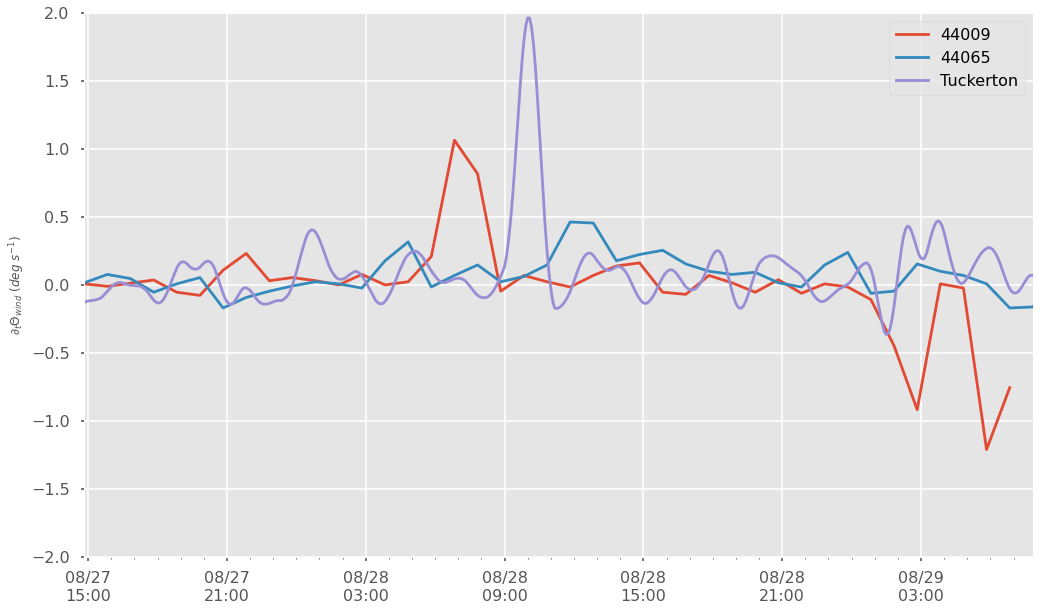

In [43]:
fig, (ax0) = plt.subplots(1,1, sharex=True, figsize=(17,10))
start = 5690
finish = 5730
ax0.plot(ndb['datenum'][start:finish],dtheta[start:finish]/dT09[start:finish]/f , label='44009')
ax0.plot(d65['datenum'],dtheta_65/dT65 /f , label='44065')
ax0.plot(tck['datenum'],dtheta_tck_filt/dTtck /f, label='Tuckerton')
ax0.set_ylim([-2,2])
ax0.legend()
ax0.set_ylabel(r'$\partial_t \Theta_{wind}$ ($deg$ $s^{-1}$)')

myFmt = mdates.DateFormatter('%m/%d\n%H:%M')
ax0.xaxis.set_minor_locator(mdates.HourLocator(interval=1))
ax0.xaxis.set_major_locator(mdates.HourLocator(interval=6))
plt.gca().xaxis.set_major_formatter(myFmt)
plt.xlim([ndb['datenum'][start],ndb['datenum'][finish]])
#plt.savefig('/Users/cew145/Desktop/ndb44009_RU16_comp.png', dpi=300, bbox_inches='tight')
plt.show()

In [44]:
filtwin = sig.windows.hamming(11)

dT = np.gradient(ndb['datenum'])*86400
dT65 = np.gradient(d65['datenum'])*86400

In [45]:
dtheta_filt = sig.convolve(dtheta,filtwin,'same')/dT
dtheta65_filt = sig.convolve(dtheta_65,filtwin,'same')/dT65

/Users/cew145/miniconda3/envs/pangeo/lib/python3.6/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  app.launch_new_instance()


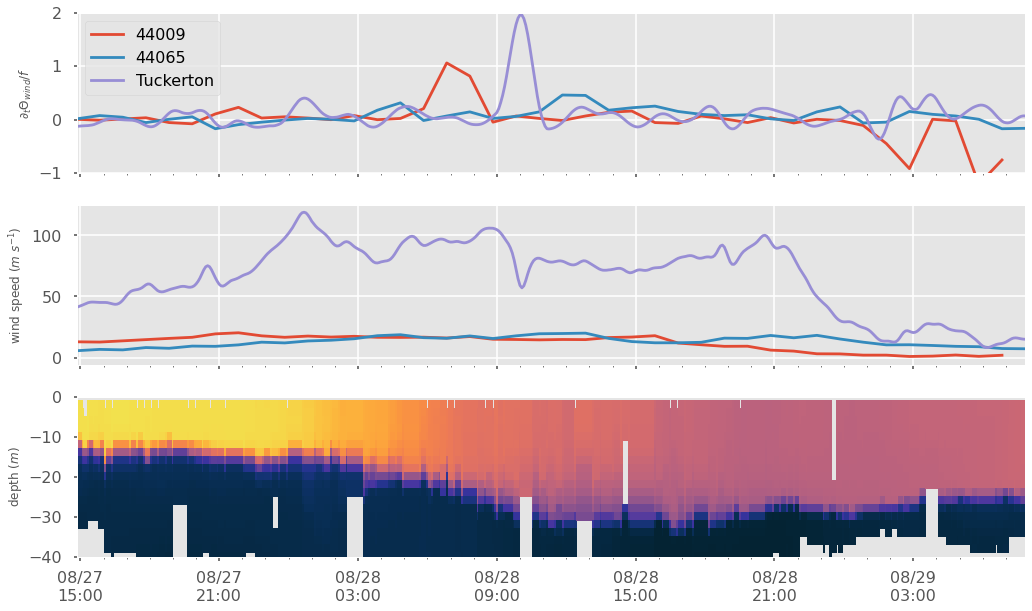

In [46]:
fig, (ax0,ax1,ax2) = plt.subplots(3,1, sharex=True, figsize=(17,10))
start = 5690
finish = 5730
ax0.plot(ndb['datenum'][start:finish],dtheta[start:finish]/dT09[start:finish]/f , label='44009')
ax0.plot(d65['datenum'],dtheta_65/dT65 /f , label='44065')
ax0.plot(tck['datenum'],dtheta_tck_filt/dTtck /f, label='Tuckerton')
ax0.set_ylim([-1,2])
ax0.legend()
ax0.set_ylabel(r'$\partial_t \Theta_{wind}/f$')
ax1.plot(ndb['datenum'][start:finish],ndb['WSPD'][start:finish], label='44009')
ax1.plot(d65['datenum'],d65['WSPD'], label='44065')
ax1.plot(tck['datenum'],sig.convolve(tck['average'],filtwin,'same'), label='Tuckerton')
#ax1.legend()
ax1.set_ylabel('wind speed ($m$ $s^{-1}$)')

temps = ax2.pcolor(MDATE, D, ru16.temperature, cmap=cmo.thermal)
#fig.colorbar(temps, ax=ax2,label='temperature ($^{\circ}C$)',pad=0.01)
ax2.set_ylim([-40,0])
ax2.set_ylabel('depth ($m$)')

myFmt = mdates.DateFormatter('%m/%d\n%H:%M')
ax2.xaxis.set_minor_locator(mdates.HourLocator(interval=1))
ax2.xaxis.set_major_locator(mdates.HourLocator(interval=6))
plt.gca().xaxis.set_major_formatter(myFmt)
plt.xlim([ndb['datenum'][start],ndb['datenum'][finish]])
#plt.savefig('/Users/cew145/Desktop/ndb44009_RU16_comp.png', dpi=300, bbox_inches='tight')
plt.show()

In [47]:
import scipy.interpolate as interp

eyepassage = mdates.date2num(datetime.datetime(2011,8,28,9))
ru16_datenums = mdates.date2num(ru16.time)
deltaT = np.abs(ru16_datenums - eyepassage)
k_eye = np.where(deltaT == np.nanmin(deltaT))[0][0]

In [48]:
profile_tmp = ru16.temperature[k_eye,:].values
d           = ru16.depth.values

def pycnocline_width(profile_tmp, d, low=10.5, high=11.5):
    finite = np.where(np.isfinite(profile_tmp))[0]
    maxdepth = d[np.min(finite)]
    mindepth = d[np.max(finite)]
    new_d = np.arange(mindepth,maxdepth,0.1)
    y = interp.interp1d(d[finite],profile_tmp[finite], kind='linear')
    new_tmp = y(new_d)
    tmp_low = np.abs(new_tmp - low)
    tmp_high = np.abs(new_tmp - high)
    q_low = np.where(tmp_low == np.nanmin(tmp_low))[0][0]
    q_high = np.where(tmp_high == np.nanmin(tmp_high))[0][0]
    #delta_d = new_d[q_high] - new_d[q_low]
    return new_d[q_high], new_d[q_low]

#print(delta_d)
#plt.plot(ru16.temperature[k_eye,:], ru16.depth)
#plt.plot(y(new_d),new_d)

In [49]:
profile_tmp = ru16.temperature[k_eye-10,:].values

low_depth  = np.ones_like(ru16['mdate'].values)
high_depth = np.ones_like(ru16['mdate'].values)

for I in range(len(ru16['mdate'].values)):
    profile_tmp = ru16.temperature[I,:].values
    a, b = pycnocline_width(profile_tmp, d, low=14, high=17)
    if np.abs(a-b) < 0.25:
        low_depth[I], high_depth[I] = np.nan, np.nan
    else:
        low_depth[I], high_depth[I] = a, b


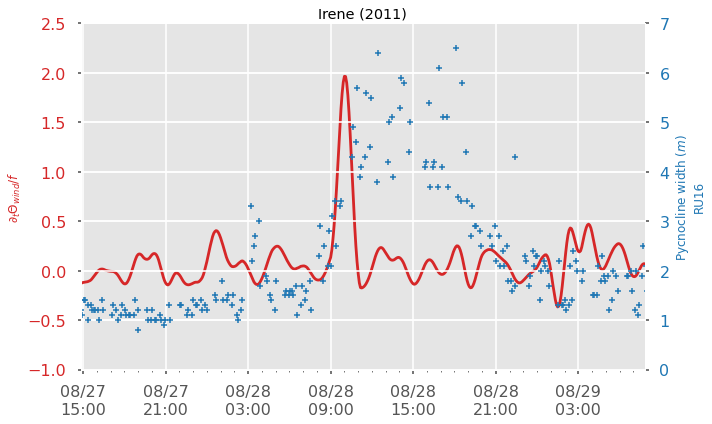

In [54]:
fig, ax1 = plt.subplots(figsize=(10,6))
plt.title('Irene (2011)')
color = 'tab:red'
#ax1.set_xlabel('date in 2011')
ax1.set_ylabel(r'$\partial_t \Theta_{wind}/f$', color=color)
ax1.plot(tck['datenum'],dtheta_tck_filt/dTtck /f, label='Tuckerton', color=color)
ax1.tick_params(axis='y', labelcolor=color)
#ax1.xaxis.grid(color='k', linestyle='-.', linewidth=0.3)
ax1.set_ylim([-1,2.5])
#ax1.grid(color=color, linestyle='-.', linewidth=0.2)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Pycnocline width ($m$)\nRU16', color=color)  # we already handled the x-label with ax1
ax2.scatter(ru16['mdate'].values, low_depth-high_depth, s=45, color=color, marker='+', linewidth=1.5)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim([0,7])
#ax2.grid(color=color, linestyle='-.', linewidth=0.2)

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%m/%d\n%H:%M"))
ax2.xaxis.set_minor_locator(mdates.HourLocator(interval=1))
ax2.xaxis.set_major_locator(mdates.HourLocator(interval=6))
plt.gca().xaxis.grid(True)
plt.xlim([ndb['datenum'][start],ndb['datenum'][finish]])

fig.tight_layout() 

plt.savefig('tuckerton_RU16_rate.pdf', bbox_inches='tight')
plt.show()

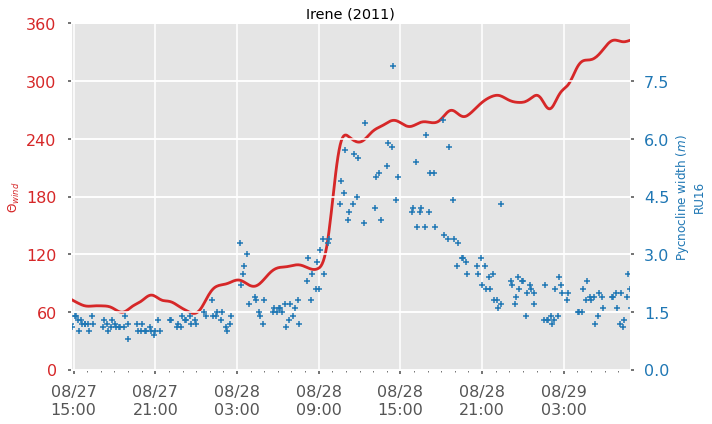

In [59]:
fig, ax1 = plt.subplots(figsize=(10,6))
plt.title('Irene (2011)')
color = 'tab:red'
#ax1.set_xlabel('date in 2011')
ax1.set_ylabel(r'$\Theta_{wind}$', color=color)
ax1.plot(tck['datenum'], theta_tck_filt, label='Tuckerton', color=color)
ax1.tick_params(axis='y', labelcolor=color)
#ax1.xaxis.grid(color='k', linestyle='-.', linewidth=0.3)
ax1.set_ylim([0,360])
ax1.set_yticks(np.arange(0,390,60))
#ax1.grid(alpha=0.5)
#ax1.grid(color=color, linestyle='-.', linewidth=0.5)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Pycnocline width ($m$)\nRU16', color=color)  # we already handled the x-label with ax1
ax2.scatter(ru16['mdate'].values, low_depth-high_depth, s=45, color=color, marker='+', linewidth=1.5)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim([0,9])
ax2.set_yticks(np.arange(0,9,1.5))
#ax2.grid(alpha=0.5)
#ax2.grid(color=color, linestyle='-.', linewidth=0.5)

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%m/%d\n%H:%M"))
ax2.xaxis.set_minor_locator(mdates.HourLocator(interval=1))
ax2.xaxis.set_major_locator(mdates.HourLocator(interval=6))
plt.gca().xaxis.grid(True)
plt.xlim([ndb['datenum'][start],ndb['datenum'][finish]])
#plt.axvline(x = eyepassage+1/24, c='r', linestyle="--")

fig.tight_layout() 

plt.savefig('tuckerton_RU16_comp.pdf', bbox_inches='tight')
plt.show()

In [43]:
df = ru16

df.depth.values
bef = df.mdate.values < eyepassage-0.5
aft = df.mdate.values > eyepassage-2.0
qb   = np.logical_and(bef,aft)
temps_bef = df.temperature.values[qb,:3]
mean_Tbef = np.nanmean(temps_bef)

bef = df.mdate.values < eyepassage+(1/24)
aft = df.mdate.values > eyepassage-(1/24)
qeye  = np.logical_and(bef,aft)
temps_eye = df.temperature.values[qeye,:3]
mean_Teye = np.nanmean(temps_eye)

bef = df.mdate.values < eyepassage+0.5
aft = df.mdate.values > eyepassage+0.25
qa   = np.logical_and(bef,aft)
temps_aft = df.temperature.values[qa,:3]
mean_Taft = np.nanmean(temps_aft)

Ahead_of_eye_cooling = mean_Tbef - mean_Teye
After_of_eye_cooling = mean_Teye - mean_Taft

print(Ahead_of_eye_cooling, After_of_eye_cooling)

4.415670423613676 1.4988097265069555


In [44]:
Pw_bef = np.nanmedian(low_depth[qb]-high_depth[qb])
Pw_eye = np.nanmedian(low_depth[qeye]-high_depth[qeye])
Pw_aft = np.nanmedian(low_depth[qa]-high_depth[qa])

Pw_bef, Pw_eye, Pw_aft, np.nanmean(high_depth[qb])-np.nanmean(high_depth[qeye])

(1.40000000000002, 2.6500000000000377, 3.7000000000000526, 12.622899159663882)

/Users/cew145/miniconda3/envs/pangeo/lib/python3.6/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  


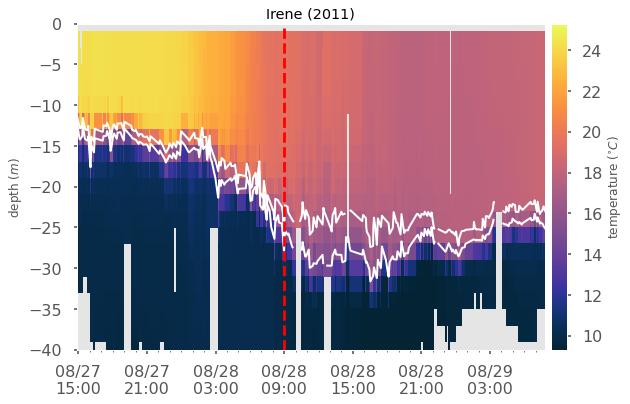

In [38]:
fig, ax = plt.subplots(1,1, sharex=True, figsize=(10,6))
temps = ax.pcolor(MDATE, D, ru16.temperature, cmap=cmo.thermal)
fig.colorbar(temps, ax=ax, label='temperature ($^{\circ}C$)',pad=0.01)
ax.set_title('Irene (2011)')
ax.contour(MDATE, D, ru16.temperature, levels=np.array([14,17]), colors='w', linewidths=2)
ax.set_ylim([-40,0])
ax.set_ylabel('depth ($m$)')
plt.axvline(x = eyepassage, c='r', linestyle="--")
ax.xaxis.set_minor_locator(mdates.HourLocator(interval=1))
ax.xaxis.set_major_locator(mdates.HourLocator(interval=6))
plt.gca().xaxis.set_major_formatter(myFmt)
plt.xlim([ndb['datenum'][start],ndb['datenum'][finish]])

plt.savefig('tuckerton_RU16_lines.png', dpi=400, bbox_inches='tight')
plt.show()

In [60]:
dense0 = 1022.8
T0     = 17
S0     = 31.5
alpha  = 0.000281
beta   = 0.000766
g      = 9.81

dense = dense0 * (1 + alpha*(ru16.temperature.values-T0) + beta*(ru16.salinity.values-S0))
buoy  = -g * dense / dense0

dz = np.gradient(df.depth.values)
db = np.gradient(buoy, axis=[1])
dbdz = -db/dz

dbdz_b = dbdz[qb,:]
dbdz_b.shape
maxN2 = np.ones(dbdz_b.shape[0])
for i in range(dbdz_b.shape[0]):
    prof = dbdz_b[i,:]
    maxN2[i] = np.nanmax(prof)
    
print("N2max =",np.nanmean(maxN2))

N2max = 0.003370266300820008


In [39]:
winddata = "../data/ndbc_years/44065h2011.txt"
winddat2 = "../data/ndbc_years/44009h2011.txt"

loc65 = [40.369, -73.703] #degN,degE
loc09 = [38.457, -74.702] #degN,degE

ndb = pd.read_csv(winddata, skiprows=[1], delim_whitespace=True)
nd2 = pd.read_csv(winddat2, skiprows=[1], delim_whitespace=True)

ndb_datenum = [mdates.date2num(datetime.datetime(ndb['#YY'][i],ndb['MM'][i],ndb['DD'][i],ndb['hh'][i],ndb['mm'][i])) 
               for i in range(len(ndb))]
ndb_datenum = np.asarray(ndb_datenum)

nd2_datenum = [mdates.date2num(datetime.datetime(nd2['#YY'][i],nd2['MM'][i],nd2['DD'][i],nd2['hh'][i],nd2['mm'][i])) 
               for i in range(len(nd2))]
nd2_datenum = np.asarray(nd2_datenum)

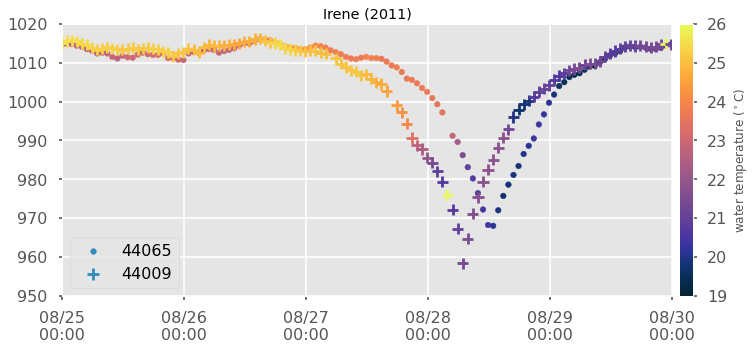

In [47]:
plt.figure(figsize=(13,5))
plt.scatter(ndb_datenum, ndb['PRES'], c=ndb['WTMP'], vmin=19, vmax=26, cmap=cmo.thermal, marker=".", label="44065")
plt.scatter(nd2_datenum, nd2['PRES'], c=nd2['WTMP'], vmin=19, vmax=26, cmap=cmo.thermal, marker="+", label="44009")
plt.colorbar(pad=0.01,label='water temperature ($^\circ$C)')
plt.xlim([plend-5, plend])
plt.legend()
eye65 = eyepassage + 3/24
eye09 = eyepassage - 2/24
plt.ylim([950,1020])
plt.title('Irene (2011)')
plt.gca().xaxis.set_major_formatter(myFmt)

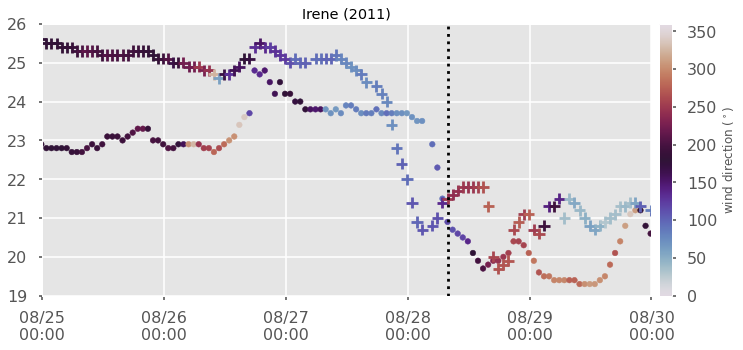

In [48]:
wtemp = ndb['WTMP'].values
wtemp[wtemp > 35] = np.nan

plt.figure(figsize=(13,5))
plt.scatter(ndb_datenum,ndb['WTMP'], marker=".", label="44065", c=ndb['WDIR'], vmax=360, vmin=0, cmap='twilight')
plt.scatter(nd2_datenum,nd2['WTMP'], marker="+", label="44009", c=nd2['WDIR'], vmax=360, vmin=0, cmap='twilight')
plt.axvline(x = eyepassage-1/24, c='k', linestyle=":")
plt.colorbar(pad=0.01,label='wind direction ($^\circ$)')
plt.xlim([plend-5, plend])
plt.ylim([19,26])
plt.title('Irene (2011)')
plt.gca().xaxis.set_major_formatter(myFmt)

In [49]:
def cooling_defs_1D(datenums,eyepassage,wtemp):
    bef = datenums < eyepassage-0.5
    aft = datenums > eyepassage-2.0
    qb   = np.logical_and(bef,aft)
    temps_bef = wtemp[qb]
    mean_Tbef = np.nanmean(temps_bef)

    bef = datenums < eyepassage+(1/24)
    aft = datenums > eyepassage-(1/24)
    qeye  = np.logical_and(bef,aft)
    temps_eye = wtemp[qeye]
    mean_Teye = np.nanmean(temps_eye)

    bef = datenums < eyepassage+0.5
    aft = datenums > eyepassage+0.25
    qa   = np.logical_and(bef,aft)
    temps_aft = wtemp[qa]
    mean_Taft = np.nanmean(temps_aft)

    Ahead_of_eye_cooling = mean_Tbef - mean_Teye
    After_of_eye_cooling = mean_Teye - mean_Taft

    return(Ahead_of_eye_cooling, After_of_eye_cooling)

In [50]:
cooling_defs_1D(ndb_datenum,eye65,ndb['WTMP'].values)

(3.62777777777778, 0.03333333333333144)

In [53]:
cooling_defs_1D(nd2_datenum,eye09,nd2['WTMP'].values)

(3.5147058823529456, 0.716666666666665)